# Определение возраста покупателя по фото
Дан набор фотографий людей с указанием возраста. Требуется построить модель, которая будет определять по фото возраст покупателя в супермаркете.

# 1. Исследовательский анализ данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
# грузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
#7591 файл изображения

features, target = next(train_gen_flow)

print(features.shape)

(32, 224, 224, 3)


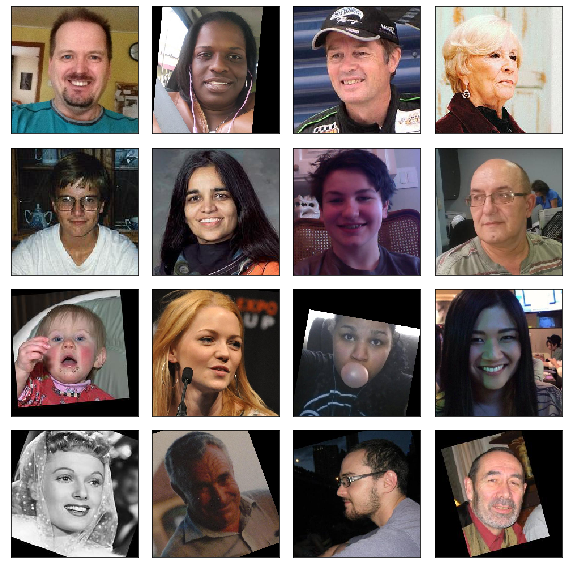

In [4]:
#Выведем 16 изображений
fig = plt.figure(figsize=(8,8))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [5]:
#Посмотрим возраст этих 16
print (target[:16])

[50 41 46 85 14 40 14 53  4 32 14 23 37 62 21 58]


In [6]:
# Посмотрим на датасет с возрастами
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


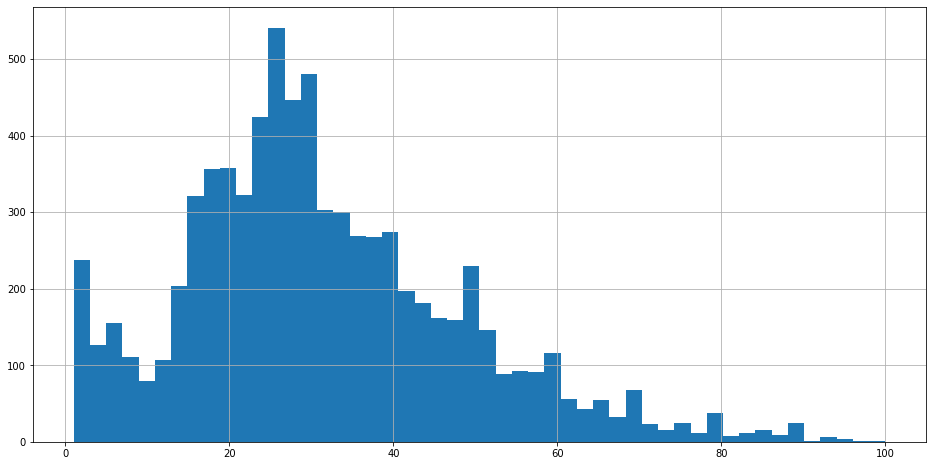

In [7]:
#Выводим график распределения возраста в выборке
labels['real_age'].hist(bins=50, figsize=(16,8))

#### Выводы по п.1
В датасете 7591 изображение. 
Судя по выборке из 16 фотографий, датасет неоднородный - представлены фото людей разных национальностей, в анфас и профиль,  некоторые фото черно-белые и из прошлого века. Что интересно - все улыбаются. Стоит добавить в датасет грустных фотографий для повышения качества. А еще не хватает фото людей в медицинских масках - они бы нейросети сейчас пригодились.

Судя по гистограмме распределения возраста в датасете, модель лучше всего научится определять людей в возрасте от 24 до 30 лет - их фотографий больше прочих.

Можно было бы удалить выбросы в районе 90-100 лет, но такой задачи не стоит.

# 2. Обучение модели

## 2.1. Код обучения модели

```python
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def load_train(path):
  labels = pd.read_csv(path + 'labels.csv')
  train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255,horizontal_flip=True)
  train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',        
        seed=12345)
  return train_gen_flow

def load_test(path):
  test_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)
  labels = pd.read_csv(path + 'labels.csv')
  test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
  return test_gen_flow

def create_model(input_shape):
  backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
  #backbone.trainable = False
  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu'))
  optimizer = Adam(lr=0.0005)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
  model.summary()  
  return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
  model.fit(train_data, 
            validation_data=test_data,
            batch_size=batch_size, epochs=epochs,
            steps_per_epoch=len(train_data),
            validation_steps=len(test_data),
            verbose=2) #, shuffle=True)
  return model  
    
```

## 2.2. Результат вывода на экран

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 51s - loss: 189.7406 - mae: 10.3067 - val_loss: 291.1310 - val_mae: 12.8386
Epoch 2/10
178/178 - 42s - loss: 114.6264 - mae: 8.0943 - val_loss: 339.1891 - val_mae: 13.6602
Epoch 3/10
178/178 - 41s - loss: 86.8647 - mae: 7.1011 - val_loss: 350.6458 - val_mae: 13.8674
Epoch 4/10
178/178 - 41s - loss: 72.1369 - mae: 6.4807 - val_loss: 185.1775 - val_mae: 10.0164
Epoch 5/10
178/178 - 41s - loss: 56.5478 - mae: 5.7194 - val_loss: 121.8097 - val_mae: 8.5929
Epoch 6/10
178/178 - 41s - loss: 49.5660 - mae: 5.3796 - val_loss: 98.4313 - val_mae: 7.4824
Epoch 7/10
178/178 - 41s - loss: 40.6158 - mae: 4.8839 - val_loss: 114.0393 - val_mae: 7.9228
Epoch 8/10
178/178 - 41s - loss: 31.7827 - mae: 4.3448 - val_loss: 93.4702 - val_mae: 7.3075
Epoch 9/10
178/178 - 41s - loss: 28.1366 - mae: 4.1014 - val_loss: 91.2166 - val_mae: 7.0071
Epoch 10/10
178/178 - 41s - loss: 24.1394 - mae: 3.7616 - val_loss: 109.3331 - val_mae: 7.7054

60/60 - 10s - loss: 109.3331 - mae: 7.7054
Test MAE: 7.7054

```

# 3. Анализ обученной модели

Задание проекта выполнена - получена MAE меньше 8 (MAE на тесте = 7.7054).

При построении нейронной сети использовалась архитектура ResNet50.

Судя по тому, что MAE, полученная на учебной выборке в 2 раза меньше MAE, полученной на тестовой выборке (3.7616 против 7.7054) модель переобучилась. Возможно, во избежание переобучения стоит уменьшить скорость обучения (сейчас learning rate = 0.0005), уменьшить количество эпох (сейчас их 10), заморозить часть сети. К сожалению, после получения требуемого результата (MAE < 8), нет возможности проверить это на практике.